In [1]:
import os

from tqdm import tqdm
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type
import torch.optim as optim

In [2]:
# ResNet18 BasicBlock
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

In [3]:
#ResNet
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        #print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [4]:
## TESTING - pass a dummy tensor through the ResNet
#tensor = torch.rand([1, 3, 224, 224])
#model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=1000)
#print(model)

## Total parameters and trainable parameters.
#total_params = sum(p.numel() for p in model.parameters())
#print(f"{total_params:,} total parameters.")
#total_trainable_params = sum(
#    p.numel() for p in model.parameters() if p.requires_grad)
#print(f"{total_trainable_params:,} training parameters.")
#output = model(tensor)

### Load and pre-process the data

In [5]:
DATA_DIR = "/home/sylvanix/Data/Open_Datasets/imagenette2"
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train")
TEST_DATA_DIR = os.path.join(DATA_DIR, "val")

from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load ImageNette dataset
trainset = datasets.ImageFolder(
        TRAIN_DATA_DIR, transform=transform
    )
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)

validset= datasets.ImageFolder(
        TEST_DATA_DIR, transform=transform
    )
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
# instantiate the model
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=1000)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the network to GPU if available
if torch.cuda.is_available():
    print("using CUDA")
    model = model.cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

using CUDA


In [7]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [8]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [11]:
import matplotlib.pyplot as plt

def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join('./', name+'_accuracy.png'))
    
    # Loss plots.
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('./', name+'_loss.png'))

[INFO]: Epoch 1 of 3
Training


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:19<00:00,  7.75it/s]

Validation



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 21.30it/s]

Training loss: 1.784, training acc: 42.750
Validation loss: 1.789, validation acc: 45.223
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:18<00:00,  8.10it/s]

Validation



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 21.50it/s]

Training loss: 1.252, training acc: 58.317
Validation loss: 1.495, validation acc: 52.382
--------------------------------------------------
[INFO]: Epoch 3 of 3
Training



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:18<00:00,  8.11it/s]

Validation



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 21.51it/s]


Training loss: 1.053, training acc: 65.403
Validation loss: 1.298, validation acc: 57.529
--------------------------------------------------
TRAINING COMPLETE


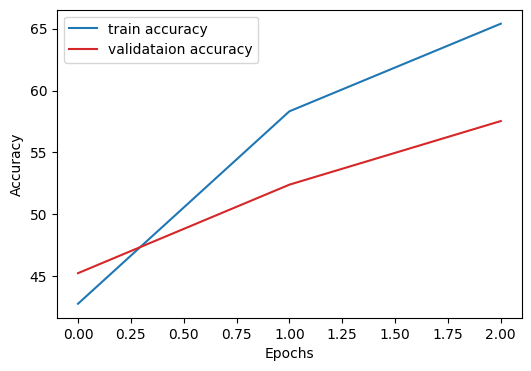

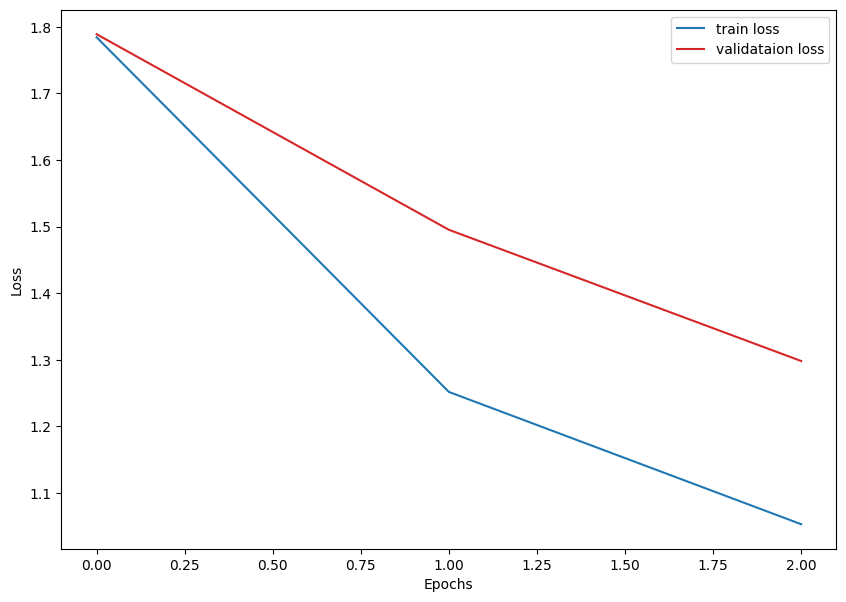

In [10]:
epochs = 3

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name="xyz"
)
print('TRAINING COMPLETE')

In [13]:
output_base_name = "./resnet18_imagenette_classifier_"

# save the entire trained model
model_path = output_base_name + "entier_model.pth"
torch.save(model, model_path)

# save the model state_dict
model_state_dict_path = output_base_name + "model_state_dict.pth"
torch.save(model.state_dict(), model_state_dict_path)

# save the optimizer state_dict
optimizer_state_dict_path = output_base_name + "optimizer_state_dict.pth"
torch.save(optimizer.state_dict(), optimizer_state_dict_path)

In [ ]:
#lbl_dict = dict(
#    n01440764='tench',
#    n02102040='English springer',
#    n02979186='cassette player',
#    n03000684='chain saw',
#    n03028079='church',
#    n03394916='French horn',
#    n03417042='garbage truck',
#    n03425413='gas pump',
#    n03445777='golf ball',
#    n03888257='parachute'
#)